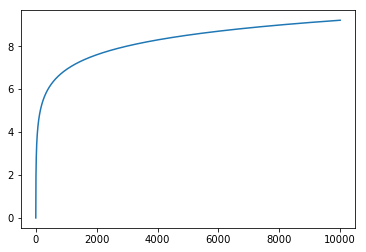

In [1]:
import matplotlib, numpy as np
import matplotlib.pyplot as plt
x = np.arange(1,10000)
y = np.log(x)

plt.plot(x,y)

plt.show()

In [2]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import cPickle as pickle
import pyamg
#import peakutils
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KernelDensity
from collections import defaultdict
from scipy.signal import argrelextrema
from sklearn.neighbors import NearestNeighbors
#from sklearn.feature_selection import SelectKBest
from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import KernelPCA
import plotly.graph_objs as go
import plotly.offline as py
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.feature_selection import chi2
import scipy.sparse as sps
#import networkx as nx
from itertools import combinations
from sklearn.cluster import KMeans, MiniBatchKMeans
import numpy as np
import time
import networkx as nx
import os
from networkx.algorithms.components import *
from collections import Counter

/Users/JoshuaLevy/anaconda/envs/JoshuaConda/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [7]:
def cluster(args):
    maindir, file, clusterMethod, n_subgenomes, metric = args
    start = time.clock()
    os.chdir(maindir)
    try:
        n_subgenomes = int(n_subgenomes)
    except:
        n_subgenomes = 2
    n_clusters = n_subgenomes + 1
    clustering_algorithms = {'SpectralClustering': SpectralClustering(n_clusters=n_clusters, eigen_solver='amg', affinity= 'precomputed', random_state=42),#,gamma=1),arpack#amg,affinity="nearest_neighbors")#, n_neighbors=30, gamma=1),# nearestneighbors
                             'KMeans': MiniBatchKMeans(n_clusters=n_clusters)}
    name, algorithm = clusterMethod , clustering_algorithms[clusterMethod]
    if 'recluster' not in file:
        #dataOld = sps.load_npz('clusteringMatrix.npz')
        scaffolds = pickle.load(open('scaffolds.p', 'rb'))
        #kmers = pickle.load(open('kmers.p', 'rb'))
        #kmerIdx = {i : kmer for i, kmer in enumerate(kmers)}
        Tname = file.split('transformed3D')[0]
        transformed_data = np.load(file)
        print 'scaled %f'%(time.clock()-start)
        t1 = time.clock()
        transformed_data = StandardScaler().fit_transform(transformed_data)
        print 'scaled_f %f'%(time.clock()-t1)
        
        if clusterMethod == 'SpectralClustering':
            neigh = NearestNeighbors(n_neighbors=10, algorithm = 'brute' , metric=metric)
            #except:
            #    print 'NN not working'
            neigh.fit(transformed_data)
            fit_data = neigh.kneighbors_graph(transformed_data)
            connected = sps.csgraph.connected_components(fit_data)
            if connected[0] > 1:
                #D_num = fit_data.sum(axis=0,dtype=np.uint8)
                #D = sps.dok_matrix((len(scaffolds), len(scaffolds)), dtype=np.uint8)
                #for i in range(len(fit_data)):
                #    D[i,i] = D_num[i]
                #D = D.tocsc()
                #L = D-fit_data
                counts = Counter(connected[1])
                subgraph_idx = max(counts.iteritems(), key=lambda x: x[1])[0]
                scaffBool = connected[1] == subgraph_idx
                #G = nx.Graph(fit_data)#nx.from_scipy_sparse_matrix(fit_data)
                #mapping = {i: scaffolds[i] for i in range(len(scaffolds))}
                #print G.nodes()
                #G = nx.relabel_nodes(G, mapping, copy=False)
                #print scaffolds[0:10], G.nodes()[0:10]
                #print list(connected_component_subgraphs(G))[0]
                #print sorted(nx.connected_components(G), key=len, reverse=True)
                #gs = list(connected_component_subgraphs(G))[0]
                #scaffolds2 = [scaffold for scaffold in scaffolds if scaffold in gs.nodes()]
                #print scaffolds2
                #s2 = gs.nodes()
                #scaffBool = np.vectorize(lambda scaffold: scaffold in s2)(scaffolds)
                #fit_data = nx.to_scipy_sparse_matrix(gs)
                #fit_data = fit_data[scaffBool].T[scaffBool]
                #dataOld = dataOld[scaffBool]
                print transformed_data[0:10,:],scaffolds[0:10]
                transformed_data = transformed_data[scaffBool,:]
                scaffolds_noconnect = list(np.array(scaffolds)[scaffBool == False])
                #print scaffolds[0:10],np.array(scaffolds2)[0:10]#, np.array(scaffolds2)[0:10]
                scaffolds = list(np.array(scaffolds)[scaffBool])
                print transformed_data[0:10,:],scaffolds[0:10]
                n_connected = connected[0]
                while(n_connected > 1):
                    neigh = NearestNeighbors(n_neighbors=10, algorithm='brute', metric=metric)
                    neigh.fit(transformed_data)
                    fit_data = neigh.kneighbors_graph(transformed_data)
                    connected = sps.csgraph.connected_components(fit_data)
                    counts = Counter(connected[1])
                    subgraph_idx = max(counts.iteritems(), key=lambda x: x[1])[0]
                    scaffBool = connected[1] == subgraph_idx
                    #fit_data = fit_data[scaffBool].T[scaffBool]
                    if connected[0] > 1:
                        #dataOld = dataOld[scaffBool]
                        transformed_data = transformed_data[scaffBool, :]
                        scaffolds_noconnect += list(np.array(scaffolds)[scaffBool == False])
                        scaffolds = list(np.array(scaffolds)[scaffBool])
                    n_connected = connected[0]
                sps.save_npz('spectralGraph2.npz', fit_data.tocsc())
                pickle.dump(scaffolds,open('scaffolds2.p', 'wb'))

                else:
                    scaffolds_noconnect = []
            print 'NN %f'%(time.clock()-start)
            """
            t2 = time.clock()
            neigh = NearestNeighbors(n_neighbors = 10,metric=metric)
            neigh.fit(transformed_data)
            fit_data = neigh.kneighbors_graph(transformed_data)
            G = nx.from_scipy_sparse_matrix(fit_data)
            mapping = {i:scaffolds[i] for i in range(len(scaffolds))}
            G=nx.relabel_nodes(G,mapping, copy=False)
            gs = list(connected_component_subgraphs(G))[0]
            scaffolds2 = gs.nodes()
            scaffBool = np.vectorize(lambda scaffold: scaffold in scaffolds2)(scaffolds)
            fit_data = nx.to_scipy_sparse_matrix(gs)
            transformed_data = transformed_data[scaffBool]
            scaffolds = scaffolds2
            # FIXME do something with thrown out points in future
            sps.save_npz('spectralGraph2.npz',fit_data)
            pickle.dump(scaffolds,open('scaffolds2.p', 'wb'))
            #sps.save_npz('spectralGraph.npz',fit_data)
            print 'NN_f %f'%(time.clock()-t2)
            #print fit_data.toarray()
            """
        else:
            fit_data = transformed_data

        #clustering_names = ['SpectralClustering','KMeans']
        #n_clusters = 3

        #clustering_algorithms = [SpectralClustering(n_clusters=n_clusters,eigen_solver='amg',affinity="nearest_neighbors", gamma=1),MiniBatchKMeans(n_clusters=3)]

        #for name, algorithm in zip(clustering_names, clustering_algorithms):
            #try:
        if 1:#os.path.exists(name + Tname + 'n%d' % n_clusters + 'ClusterTest.html') == 0:
            print 'cluster %f'%(time.clock()-start)
            t3 = time.clock()
            algorithm.fit(fit_data)
            print 'cluster_f %f'%(time.clock()-t3)
            if n_subgenomes > 2:
                reduction = KernelPCA(n_components=3)
                reduction.fit(transformed_data)
                reductionT = reduction.transform(transformed_data)
                scaledfit = StandardScaler()
                scaledfit.fit(reductionT)
                transformed_data2 = scaledfit.transform(reductionT)
            else:
                transformed_data2 = transformed_data
            if hasattr(algorithm, 'labels_'):
                y_pred = algorithm.labels_.astype(np.int)
            else:
                y_pred = algorithm.predict(transformed_data)
            N = len(set(y_pred))
            c = ['hsl(' + str(h) + ',50%' + ',50%)' for h in np.linspace(0, 360, N)]
            # plot
            plots = []
            clusterSize = defaultdict(list)
            try:
                os.mkdir('analysisOutputs/')
            except:
                pass
            try:
                os.mkdir('analysisOutputs/' + name + Tname + 'n%d' % n_clusters)
            except:
                pass

            for key in set(y_pred):
                # print key
                cluster_scaffolds = np.array(scaffolds)[y_pred == key]
                if list(cluster_scaffolds):
                    clusterSize[key] = np.mean(np.apply_along_axis(lambda x: np.linalg.norm(x),1,transformed_data[y_pred == key,:]))#len(cluster_scaffolds)
                    if clusterSize[key] == min(clusterSize.values()):
                        testCluster = key
                    plots.append(
                        go.Scatter3d(x=transformed_data2[y_pred == key, 0], y=transformed_data2[y_pred == key, 1],
                                     z=transformed_data2[y_pred == key, 2],
                                     name='Cluster %d, %d points, %f distance' % (key, len(cluster_scaffolds),clusterSize[key]), mode='markers',
                                     marker=dict(color=c[key], size=2), text=cluster_scaffolds))

            if hasattr(algorithm, 'cluster_centers_'):
                if n_subgenomes > 2:
                    centers = scaledfit.transform(reduction.transform(algorithm.cluster_centers_)) #FIXME modify!!! need scaler fitted model from transformeddata
                else:
                    centers = algorithm.cluster_centers_
                plots.append(
                    go.Scatter3d(x=centers[:, 0], y=centers[:, 1], z=centers[:, 2], mode='markers',
                                 marker=dict(color='purple', symbol='circle', size=12),
                                 opacity=0.4,
                                 name='Centroids'))
            for key in set(y_pred)-{testCluster}:
                with open('analysisOutputs/' + name + Tname + 'n%d' % n_clusters + '/subgenome_%d.txt' % key, 'w') as f:
                    f.write('\n'.join(np.array(scaffolds)[y_pred == key]))

            fig = go.Figure(data=plots)

            #trainData = transformed_data[y_pred != testCluster]
            #trainData_scaffolds = np.array(scaffolds)[y_pred != testCluster]

            """
            trainLabels = y_pred[y_pred != testCluster]
            trainData = dataOld[y_pred != testCluster]
            kbest = SelectKBest(chi2,k = 500)
            kbest.fit(trainData,trainLabels)
            bestFeatures = kbest.pvalues_.argsort()[:500]
            best_500_kmers = [kmers[i] for i in bestFeatures]
            sps.save_npz('%s/recluster%s_clusteringMatrix.npz' %(reclusterFolder, name + Tname + 'n%d' % n_clusters), dataOld[:,bestFeatures])#.tocsc()#.tocoo())
            with open('%s/kmer500Best_%s.fa'%(kmer500Path,name + Tname + 'n%d' % n_clusters),'w') as f:
                f.write('\n'.join('>%s\n%s'%(kmer,kmer) for kmer in best_500_kmers))
            subprocess.call('touch ' + 'analysisOutputs/' + name + Tname + 'n%d' % n_clusters + '.txt',
                            shell=True)"""

            py.plot(fig, filename=name + Tname + 'n%d' % n_clusters + 'ClusterTest.html')
    
def clusterGraph():
    G = nx.from_scipy_sparse_matrix(sps.load_npz('spectralGraph2.npz'))
    scaffolds = pickle.load(open('scaffolds2.p', 'rb'))
    mapping = {i:scaffolds[i] for i in range(len(scaffolds))}
    G=nx.relabel_nodes(G,mapping, copy=False)
    pos = nx.spring_layout(G,dim=3)
    plots = []
    nodes = G.nodes()
    N = 2
    c = ['hsl(' + str(h) + ',50%' + ',50%)' for h in np.linspace(0, 360, N+1)]
    Xv = [pos[k][0] for k in nodes]
    Yv = [pos[k][1] for k in nodes]
    Zv = [pos[k][2] for k in nodes]
    nodesText = ['%s, %d connections'%(kmer, int(G.degree(kmer))) for kmer in nodes]#, Related: %s'%(kmer, int(G.degree(kmer)), ' '.join(G[kmer].keys())) for kmer in nodes]
    Xed = []
    Yed = []
    Zed = []
    for edge in G.edges():
        Xed += [pos[edge[0]][0], pos[edge[1]][0], None]
        Yed += [pos[edge[0]][1], pos[edge[1]][1], None]
        Zed += [pos[edge[0]][2], pos[edge[1]][2], None]
    plots.append(go.Scatter3d(x=Xv,
                          y=Yv,
                          z=Zv,
                          mode='markers',
                          name='Scaffolds',
                          marker=go.Marker(symbol='dot',
                                           size=5,
                                           color=c[0],
                                           line=go.Line(color='rgb(50,50,50)', width=0.5)
                                           ),
                          text=nodesText,
                          hoverinfo='text'
                          ))
    plots.append(go.Scatter3d(x=Xed,
                              y=Yed,
                              z=Zed,
                              mode='lines',
                              line=go.Line(color='rgb(210,210,210)', width=1),
                              hoverinfo='none'
                              ))
    axis = dict(showbackground=False,
            showline=False,
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            title=''
            )

    layout = go.Layout(
        title="Graph of Scaffolds",
        width=1000,
        height=1000,
        showlegend=True,
        scene=go.Scene(
            xaxis=go.XAxis(axis),
            yaxis=go.YAxis(axis),
            zaxis=go.ZAxis(axis),
        ),
        margin=go.Margin(
            t=100
        ),
        hovermode='closest',
        annotations=go.Annotations([
            go.Annotation(
                showarrow=False,
                text="",
                xref='paper',
                yref='paper',
                x=0,
                y=0.1,
                xanchor='left',
                yanchor='bottom',
                font=go.Font(
                    size=14
                )
            )
        ]), )
    data1 = go.Data(plots)
    fig1 = go.Figure(data=data1, layout=layout)
    py.plot(fig1, filename='SpectralGraph.html')

SyntaxError: invalid syntax (<ipython-input-7-6d12702e15de>, line 82)

In [8]:
start = time.clock()
print time.clock()
species = 'coffee'#Napus # FIXME add n_neighbors as variable!!!!
n = 2#2
os.chdir('/Users/JoshuaLevy/PycharmProjects/jupyter/')
cluster(('ClusteringMatrices/%s/'%species,'main_factor_2_transformed3D.npy','SpectralClustering',n,'cosine'))
print 'total time = ' + str(time.clock() - start)
os.chdir('/Users/JoshuaLevy/PycharmProjects/jupyter/')
os.chdir('ClusteringMatrices/%s/'%species)
clusterGraph()

18.544982
scaled 0.018226
scaled_f 0.003403
NN 12.683726
cluster 12.683862
cluster_f 1.462721
total time = 14.710624


IOError: [Errno 2] No such file or directory: 'spectralGraph2.npz'

In [ ]:
time.clock()

In [ ]:
start = time.clock()
print time.clock()
os.chdir('/Users/JoshuaLevy/PycharmProjects/jupyter/')
cluster(('ClusteringMatrices/sweetpotato/','main_factor_3_transformed3D.npy','SpectralClustering',3,'cosine'))
print 'total time = ' + str(time.clock() - start)

In [ ]:
start = time.clock()
print time.clock()
os.chdir('/Users/JoshuaLevy/PycharmProjects/jupyter/')
cluster(('ClusteringMatrices/ABR/','main_factor_2_transformed3D.npy','SpectralClustering',2,'euclidean'))
print 'total time = ' + str(time.clock() - start)

2.912739
scaled 0.009103
scaled_f 0.001315
NN 0.010699
NN_f 0.136532
cluster 0.147768


/Users/JoshuaLevy/anaconda/envs/JoshuaConda/lib/python2.7/site-packages/sklearn/utils/validation.py:678: UserWarning:

Array is not symmetric, and will be converted to symmetric by average with its transpose.



cluster_f 0.664483
total time = 1.153597


In [8]:
os.chdir('/Users/JoshuaLevy/PycharmProjects/jupyter/')
os.chdir('ClusteringMatrices/tobacco/')
a=sps.load_npz('spectralGraph.npz')
b = sps.linalg.qr(a)[1]
b = sps.absolute(b)
b = sps.sum(b,axis=1)
print b

LinAlgError: 0-dimensional array given. Array must be two-dimensional

In [ ]:
a = np.load('ClusteringMatrices/tobacco/main_factor_2_transformed3D.npy')
s = SpectralClustering(n_clusters=2,affinity='cosine')
s.fit(a)

In [5]:
os.chdir('/Users/JoshuaLevy/PycharmProjects/jupyter/')
os.chdir('ClusteringMatrices/tobacco/')
clusterGraph()

In [6]:
from networkx.algorithms.components import *


os.chdir('/Users/JoshuaLevy/PycharmProjects/jupyter/')
os.chdir('ClusteringMatrices/tobacco/')
transformed_data = np.load('main_factor_2_transformed3D.npy')
G = nx.from_scipy_sparse_matrix(sps.load_npz('spectralGraph.npz'))
scaffolds = pickle.load(open('scaffolds.p', 'rb'))
mapping = {i:scaffolds[i] for i in range(len(scaffolds))}
G=nx.relabel_nodes(G,mapping, copy=False)
s = list(connected_components(G))
s
len(s)
[len(comp) for comp in s]
gs = list(connected_component_subgraphs(G))
len(gs[0].nodes())
G2 = gs[0]
scaffolds2 = gs[0].nodes()
scaffBool = np.vectorize(lambda scaffold: scaffold in scaffolds2)(scaffolds)
fit_data = nx.to_scipy_sparse_matrix(G2)
transformed_data2 = transformed_data[scaffBool]


print [len(x) for x in [transformed_data,transformed_data2,scaffolds,scaffolds2]]



[39003, 37828, 39003, 37828]


In [19]:
len(transformed_data[scaffBool==0])
transformed_data3 = transformed_data[scaffBool == 0]
#transformed_data3 = transformed_data[1==0]
# need command for if transformed_data is empty
print transformed_data3
randData = transformed_data[0:1000]
if list(transformed_data3): # this is it!!!
    newData = np.concatenate((randData,transformed_data3),axis=0)
else:
    newData = randData
print len(newData),len(randData), len(transformed_data3)
# watch out for 3D transformation (don't do it), incorporate the missing data towards end of pipeline

print newData
#'Related:' + ' '.join(G['BhS4_22725000_22800000'].keys())

# maybe add plotting function and graph display function to pipeline!!!
# take 3D array and graph as input

[[-0.35688989  0.39238703 -0.85107428]
 [-0.35688989  0.39238703 -0.85107428]
 [-0.35688989  0.39238703 -0.85107428]
 ..., 
 [-0.35689181  0.39238601 -0.85107116]
 [-0.35689181  0.39238601 -0.85107116]
 [-0.35689181  0.39238601 -0.85107116]]
2175 1000 1175
[[-0.39931988  0.30510213 -0.78712323]
 [-1.11586464 -0.31663183 -0.26559388]
 [-1.08804481 -0.5875726   2.11485444]
 ..., 
 [-0.35689181  0.39238601 -0.85107116]
 [-0.35689181  0.39238601 -0.85107116]
 [-0.35689181  0.39238601 -0.85107116]]


In [9]:
os.chdir('/Users/JoshuaLevy/PycharmProjects/jupyter/')
os.chdir('ClusteringMatrices/tobacco/')

In [16]:
L = nx.normalized_laplacian_matrix(G)

2.807954
scaled 0.016295
scaled_f 0.002114
[[-0.27159311 -0.27609589 -0.42804876]
 [-0.31553673 -0.22752947 -0.64770617]
 [ 0.77790674  0.18563099 -0.36398387]
 [-0.28932191 -0.03002611 -0.34328865]
 [-0.30114305 -0.27000546 -0.48956632]
 [-0.26255213 -0.26395199 -0.39824159]
 [-0.30478831 -0.29226292 -0.32462968]
 [-0.28661618 -0.15494178 -0.35881941]
 [-0.25864657 -0.24354612 -0.38718757]
 [-0.31256336 -0.33030357 -0.55078548]] ['chrA01_0_75000', 'chrA01_10050000_10125000', 'chrA01_10125000_10200000', 'chrA01_10200000_10275000', 'chrA01_10275000_10350000', 'chrA01_10350000_10425000', 'chrA01_10425000_10500000', 'chrA01_10500000_10575000', 'chrA01_1050000_1125000', 'chrA01_10575000_10650000']
[[-0.27159311 -0.27609589 -0.42804876]
 [-0.31553673 -0.22752947 -0.64770617]
 [ 0.77790674  0.18563099 -0.36398387]
 [-0.28932191 -0.03002611 -0.34328865]
 [-0.30114305 -0.27000546 -0.48956632]
 [-0.26255213 -0.26395199 -0.39824159]
 [-0.30478831 -0.29226292 -0.32462968]
 [-0.28661618 -0.1549417

/Users/JoshuaLevy/anaconda/envs/JoshuaConda/lib/python2.7/site-packages/sklearn/utils/validation.py:678: UserWarning:

Array is not symmetric, and will be converted to symmetric by average with its transpose.



cluster_f 1.017360
total time = 12.076803


In [21]:
G2 = G.clique_removal()

AttributeError: 'Graph' object has no attribute 'clique_removal'

In [ ]:
start = time.clock()
print time.clock()
os.chdir('/Users/JoshuaLevy/PycharmProjects/jupyter/')
cluster(('ClusteringMatrices/tobacco/','main_factor_2_transformed3D.npy','SpectralClustering',2,'cosine'))
print 'total time = ' + str(time.clock() - start)
os.chdir('/Users/JoshuaLevy/PycharmProjects/jupyter/')
os.chdir('ClusteringMatrices/tobacco/')
clusterGraph()

1042.944103
scaled 0.042255
scaled_f 0.006972
NN 0.049491
NN_f 469.529096
cluster 469.587580


/Users/JoshuaLevy/anaconda/envs/JoshuaConda/lib/python2.7/site-packages/sklearn/utils/validation.py:678: UserWarning:

Array is not symmetric, and will be converted to symmetric by average with its transpose.

/Users/JoshuaLevy/anaconda/envs/JoshuaConda/lib/python2.7/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



LinAlgError: the leading minor of order 8 of 'b' is not positive definite. The factorization of 'b' could not be completed and no eigenvalues or eigenvectors were computed.

In [58]:
G2 = nx.find_cliques(G)
n = nx.graph_clique_number(G)
print G2
print n

<generator object find_cliques at 0x13b728b40>
10


In [37]:
nx.node_clique_number(G)

{'BhS4_22725000_22800000': 6,
 'BhS7_8925000_9000000': 6,
 'BhS2_20925000_21000000': 7,
 'BhD1_21675000_21750000': 4,
 'BhD1_24900000_24975000': 6,
 'BhS1_28950000_29025000': 6,
 'BhS6_19425000_19500000': 6,
 'BhS5_8775000_8850000': 4,
 'BhS8_3000000_3075000': 6,
 'BhD2_37275000_37350000': 8,
 'BhD4_34200000_34275000': 5,
 'BhD1_72750000_72825000': 5,
 'BhD2_53550000_53625000': 5,
 'BhS2_10200000_10275000': 6,
 'BhD2_39375000_39450000': 6,
 'BhD2_57825000_57900000': 6,
 'BhD1_72450000_72525000': 4,
 'BhD1_46200000_46275000': 6,
 'BhS9_8475000_8550000': 4,
 'BhS5_6375000_6450000': 7,
 'BhD5_18825000_18900000': 5,
 'BhD4_13125000_13200000': 6,
 'BhS4_24675000_24750000': 5,
 'BhS9_17625000_17700000': 5,
 'BhD3_150000_225000': 7,
 'BhD3_6150000_6225000': 5,
 'BhD1_56775000_56850000': 7,
 'BhS1_14700000_14775000': 6,
 'BhD1_67725000_67800000': 6,
 'BhD4_15900000_15975000': 7,
 'BhD1_6750000_6825000': 5,
 'BhS4_8325000_8400000': 7,
 'BhD1_59925000_60000000': 5,
 'BhD3_8700000_8775000': 7,
 '

In [59]:
G4 = list(nx.k_clique_communities(G,4,G2))

In [60]:
[len(item) for item in G4]

[5654,
 209,
 58,
 29,
 126,
 173,
 48,
 107,
 85,
 4,
 4,
 50,
 36,
 4,
 5,
 62,
 15,
 37,
 12,
 43,
 23,
 5,
 27,
 19,
 5,
 22,
 31,
 4,
 14,
 19,
 6,
 23,
 12,
 12,
 5,
 15,
 42,
 6,
 4,
 15,
 16,
 17,
 4,
 14,
 5,
 12,
 4,
 6,
 4,
 12,
 5,
 6,
 5,
 11,
 5,
 4,
 6,
 4,
 4,
 4,
 14,
 5,
 4,
 6,
 4,
 5,
 5,
 4,
 4,
 4,
 5,
 4,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4]

In [ ]:
from networkx.algorithms.approximation import min_edge_dominating_set, max_clique
maxC = max_clique(G)
maxC

In [82]:
from networkx.algorithms.approximation import min_edge_dominating_set, max_clique
S = list(nx.algorithms.approximation.min_edge_dominating_set(G))
S
len(G.edges())
len(S)

3913

In [ ]:
L2 = np.nonzero(L)
L2
L1 = L[L != 1]
L1


In [75]:
from networkx.algorithms.clique import make_max_clique_graph


cliq = make_max_clique_graph(G)
cliq

In [76]:
sps.save_npz('clique_graph.npz',nx.to_scipy_sparse_matrix(cliq))

In [79]:
len(cliq.nodes())
len(G.nodes())

6796

In [94]:
from networkx.algorithms.components import *
s = list(connected_components(G))
s
len(s)
[len(comp) for comp in s]
gs = list(connected_component_subgraphs(G))
len(gs[0].nodes())
gs[0].nodes()


['Nt05_32850000_32925000',
 'Nt23_46050000_46125000',
 'Nt18_100950000_101025000',
 'Nt17_64050000_64125000',
 'Nt19_130500000_130575000',
 'Nt04_127050000_127125000',
 'Nt10_103650000_103725000',
 'Nt01_20025000_20100000',
 'Nt23_45450000_45525000',
 'Nt05_85575000_85650000',
 'Nt13_49875000_49950000',
 'Nt09_42000000_42075000',
 'Nt01_8250000_8325000',
 'Nt03_24975000_25050000',
 'Nt04_12075000_12150000',
 'Nt20_98775000_98850000',
 'Nt05_33375000_33450000',
 'Nt05_42975000_43050000',
 'Nt23_93375000_93450000',
 'Nt17_191700000_191775000',
 'Nt20_46650000_46725000',
 'Nt12_124350000_124425000',
 'Nt23_85875000_85950000',
 'Nt22_54450000_54525000',
 'Nt06_17250000_17325000',
 'Nt15_41700000_41775000',
 'Nt04_5550000_5625000',
 'Nt13_3750000_3825000',
 'Nt15_42600000_42675000',
 'Nt17_33000000_33075000',
 'Nt17_117075000_117150000',
 'Nt05_600000_675000',
 'Nt21_11400000_11475000',
 'Nt15_86250000_86325000',
 'Nt23_85200000_85275000',
 'Nt22_142725000_142800000',
 'Nt09_35100000_351750